Recordemos que en nuestro antiguo notebook sobre modelos (_Modelos2.ipynb_) encontramos los mejores modelos y transformaciones para nuestras variables. Pero sin embargo, no hicimos ningún estudio de su importancia ni su correlación, simplemente empleamos los modelos.

Por lo que en este Notebook vamos a realizar la selección de variables que mejoran nuestro modelo.

Tenemos que IDEA_pc_1960 y IDEA_pc_1960_69 son la misma variable, por lo que eliminamos IDEA_pc_1960.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Carga y procesado de datos

In [124]:
df = pd.read_csv('df_train_arreglado1.csv', sep = '|', encoding='utf-8')

# Añadimos una nueva variable que es si la longitud de la descripción es nula, va de 0 a 1000 carácteres, ó supera los 1000
df['PV_longitud_descripcion2'] = pd.cut(df['PV_longitud_descripcion'], bins = [-1,0,1000, np.inf], labels=['Ninguna', 'Media', 'Larga'], include_lowest=False)

# Precio de euro el metro
df['PV_precio_metro'] = df.HY_precio/df.HY_metros_totales

# Cambiamos Provincias por 'Castellón','Murcia','Almería','Valencia','Otros'
def estructurar_provincias(x):
    '''
    Funcion que asocia a x (Nombre de provincia) su clase
    '''
    # Lista de clases que nos queremos quedar
    if x in ['Castellón','Murcia','Almería','Valencia']:
        return x
    else:
        return 'Otros'
df['PV_provincia'] = df.HY_provincia.apply(lambda x: estructurar_provincias(x))

# Una nueva que es si el  inmueble presenta alguna distribución
df.loc[df['PV_longitud_distribucion'] > 0,'PV_longitud_distribucion'] = 1

# Cambiamos certificado energetico a Si/No (1/0)
df['PV_cert_energ'] = df['HY_cert_energ'].apply(lambda x: np.sum(x != 'No'))

# Cambiamos las categorías de HY_tipo a solo 3: [Piso, Garaje, Otros]
def CategorizarHY_tipo(dato):
    if dato in ['Piso', 'Garaje']:
        return dato
    else:
        return 'Otros'
df['PV_tipo'] = df['HY_tipo'].apply(CategorizarHY_tipo)

# Cambiamos la variable Garaje a Tiene/No tiene (1/0)
df.loc[df['HY_num_garajes']>1,'HY_num_garajes'] = 1

# Cambiamos baños por 0, 1, +1 (No tiene, tiene 1, tiene mas de 1)
df['PV_num_banos'] = pd.cut(df['HY_num_banos'], [-1,0,1,np.inf], labels = [0,1,'+1'])

# Cambiamos Num terrazas a Si/No (1/0)
df.loc[df['HY_num_terrazas']>1, 'HY_num_terrazas'] = 1

# Eliminamos los outliers de la variable respuesta y le aplicamos la transformación log(y+1) 
#         (Recordemos que el +1 es para evitar los 0 de nuestra variable)
cota = df.TARGET.mean()+3*df.TARGET.std()
print('{} outliers han sido eliminados'.format(np.sum(df.TARGET>cota)))
df = df[df.TARGET<=cota]
df['TARGET'] = np.log(df['TARGET']+1)

147 outliers han sido eliminados


Definimos las varaibles que ya no necesitamos

In [125]:
drop_vars = ['HY_id', 'HY_cod_postal', 'HY_provincia', 'HY_descripcion',
             'HY_distribucion', 'HY_tipo', 'HY_antiguedad','HY_num_banos', 'HY_cert_energ',
             'HY_num_garajes', 'IDEA_pc_1960', 'IDEA_area', 'IDEA_poblacion', 'IDEA_densidad', 'IDEA_ind_elasticidad',
             'Viejos', 'Medios','Nuevos']

Creamos los conjuntos de variables expolicativas y variable respuesta

In [126]:
X = df.drop(drop_vars+['TARGET'],axis = 1)
y = df.TARGET.copy()

Definimos las variables Dummy

In [127]:
dummy_vars = ['PV_provincia','PV_longitud_descripcion2',
              'PV_clase_piso','PV_tipo','PV_num_banos']

Y las añadimos

In [128]:
X = X.join(pd.get_dummies(X[dummy_vars]))

# Eliminamos las variables que ya n necesitamos
X = X.drop(dummy_vars, axis=1)

# Feature selection

In [26]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# Métrica
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

Recordemos que nuestro modelo que mejor se ajustaba a los datos era un XGB con 46 estimadores, por lo que vamos a realizar un primer filter utilizando las **feature\_importances\_** de este modelo.

In [42]:
xgb_model = XGBRegressor(max_depth = 10, n_estimators= 46, random_state=7)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print('XGB:',median_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1))

XGB: 17.50161647796631


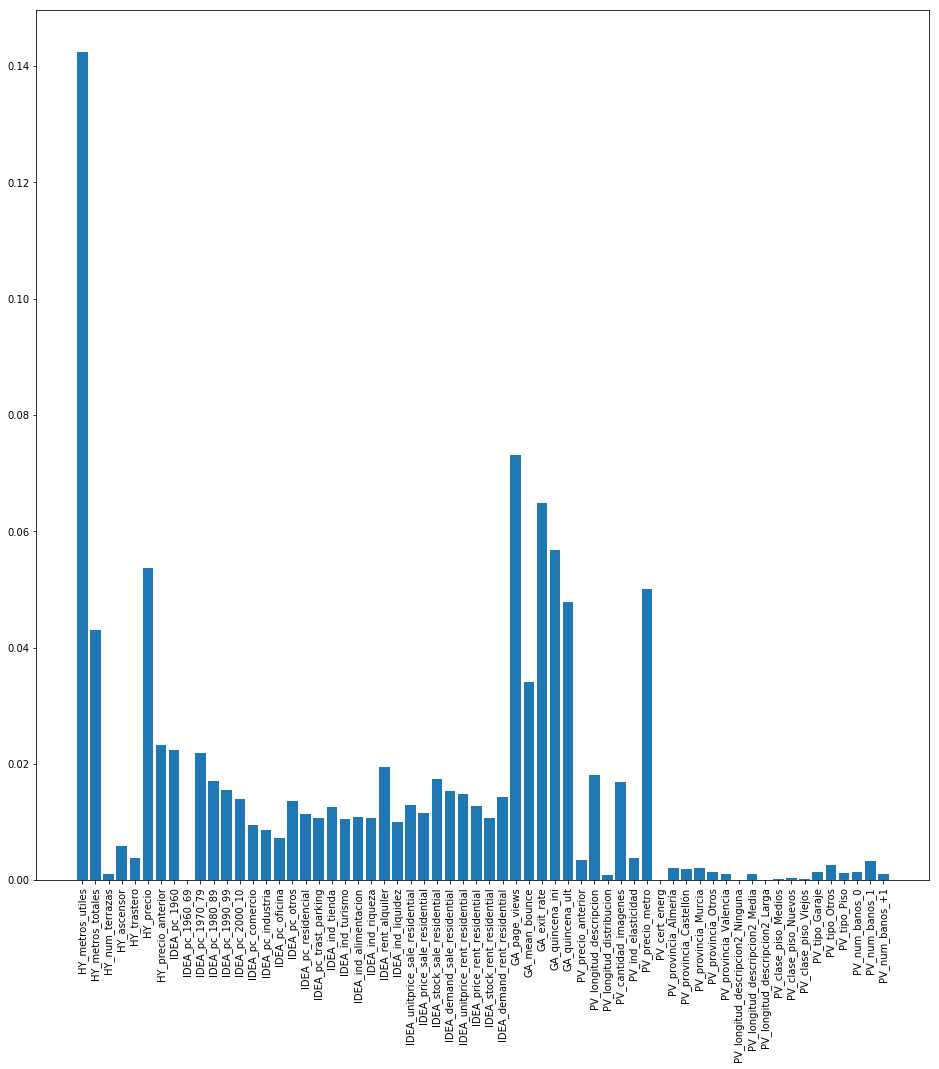

In [43]:
plt.figure(figsize=(16,16))
plt.bar(range(len(X_train.columns)), xgb_model.feature_importances_)
plt.xticks(range(len(X_train.columns)), list(X_train.columns), rotation = 90)
plt.show()

In [31]:
selected_vars = [
       'HY_metros_utiles', 'HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio', 'HY_precio_anterior',
       'IDEA_pc_1960', 'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
       'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez',
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential',
       'GA_page_views', 'GA_mean_bounce', 'GA_exit_rate', 'GA_quincena_ini',
       'GA_quincena_ult', 'PV_precio_anterior', 'PV_longitud_descripcion',
       'PV_longitud_distribucion', 'PV_cantidad_imagenes',
       'PV_ind_elasticidad', 'PV_precio_metro']

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[selected_vars], y, test_size=0.3, random_state=7)

In [34]:
xgb_model = XGBRegressor(max_depth = 10, n_estimators= 46, random_state=7)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print('XGB:',median_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1))

XGB: 18.656364822387687


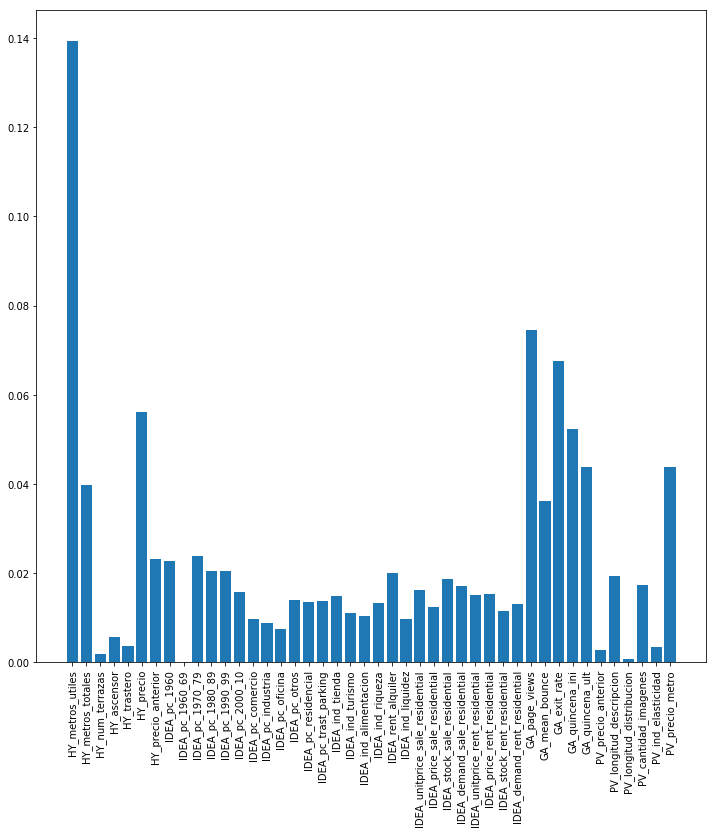

In [38]:
plt.figure(figsize=(12,12))
plt.bar(range(len(X_train.columns)), xgb_model.feature_importances_)
plt.xticks(range(len(X_train.columns)), list(X_train.columns), rotation = 90)
plt.show()

Volvemos a definir el conjunto de modelos y la función que los entrena

In [206]:
models = {
    'KNeighborsRegressor5':neighbors.KNeighborsRegressor(5, weights='uniform'),# Admite 'distance'
    'KNeighborsRegressor10':neighbors.KNeighborsRegressor(10, weights='uniform'),
    'KNeighborsRegressor15':neighbors.KNeighborsRegressor(15, weights='uniform'),
    'KNeighborsRegressor25':neighbors.KNeighborsRegressor(25, weights='uniform'),
    'KNeighborsRegressor15dist':neighbors.KNeighborsRegressor(15, weights='distance'),
    'DecisionTreeRegressor5':tree.DecisionTreeRegressor(max_depth = 5),
    'DecisionTreeRegressor10':tree.DecisionTreeRegressor(max_depth = 10),
    'DecisionTreeRegressor10':tree.DecisionTreeRegressor(max_depth = 20),
    'RandomForestRegressor20':RandomForestRegressor(max_depth=5, n_estimators = 20, random_state=0),
    'RandomForestRegressor40':RandomForestRegressor(max_depth=3, n_estimators = 40, random_state=0),
    'RandomForestRegressor50':RandomForestRegressor(max_depth=10, n_estimators = 50, random_state=0),
    'RandomForestRegressor100':RandomForestRegressor(max_depth=10, n_estimators = 100, random_state=0),
    'RandomForestRegressor150':RandomForestRegressor(max_depth=10, n_estimators = 150, random_state=0),
    'ExtraTreesRegressor10':ExtraTreesRegressor(n_estimators=10,random_state=0),
    'ExtraTreesRegressor50':ExtraTreesRegressor(n_estimators=50,random_state=0),
    'ExtraTreesRegressor100':ExtraTreesRegressor(n_estimators=100, random_state=0),
    'ExtraTreesRegressor150':ExtraTreesRegressor(n_estimators=150, random_state=0),
    'GradientBoostingRegressor30':GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, max_depth=1, random_state=0, loss='ls'),
    'GradientBoostingRegressor50':GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=1, random_state=0, loss='ls'),
    'GradientBoostingRegressor100':GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls'),
    'GradientBoostingRegressor30_md5':GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, max_depth=5, random_state=0, loss='ls'),
    'GradientBoostingRegressor50_md5':GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=0, loss='ls'),
    'GradientBoostingRegressor100_md5':GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='ls'),
    'GradientBoostingRegressor30_md10':GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, max_depth=10, random_state=0, loss='ls'),
    'GradientBoostingRegressor50_md10':GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=10, random_state=0, loss='ls'),
    'GradientBoostingRegressor100_md10':GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=0, loss='ls'),
    'XGB25':XGBRegressor(max_depth = 10, n_estimators=25, random_state=7),
    'XGB46':XGBRegressor(max_depth = 10, n_estimators=46, random_state=7),
    'XGB60':XGBRegressor(max_depth = 10, n_estimators=60, random_state=7),
    'XGB100':XGBRegressor(max_depth = 10, n_estimators=100, random_state=7),
    'XGB40_md15':XGBRegressor(max_depth = 15, n_estimators=50, random_state=7)
    }

Definimos una base de error para poder calcular una estimación de si mejoramos o empeoramos con la nueva selección de variables

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

errores = {}
    
for name, model in models.items():
    
    model = model.fit(X_train, y_train)
    y_test_predict = model.predict(X_test)
    errores[name] = median_absolute_error(np.exp(y_test)-1, np.exp(y_test_predict)-1)
    
    print(name,': ', errores[name], sep = '')

KNeighborsRegressor5: 24.30983915010443
KNeighborsRegressor10: 22.745068397330666
KNeighborsRegressor15: 22.153265022884167
KNeighborsRegressor25: 22.28241172056865
KNeighborsRegressor15dist: 22.749221050035054
DecisionTreeRegressor5: 19.87558033613938
DecisionTreeRegressor10: 27.185000000000002
RandomForestRegressor20: 18.93625109238917
RandomForestRegressor40: 19.342760548404588
RandomForestRegressor50: 19.103013601454176
RandomForestRegressor100: 19.204794563105466
RandomForestRegressor150: 19.24011461323539
ExtraTreesRegressor10: 20.793456527041812
ExtraTreesRegressor50: 19.66458101652902
ExtraTreesRegressor100: 19.28982516522425
ExtraTreesRegressor150: 19.413730753385646
GradientBoostingRegressor30: 20.485136576385145
GradientBoostingRegressor50: 19.930312949760697
GradientBoostingRegressor100: 20.16058700008653
GradientBoostingRegressor30_md5: 19.240834006834355
GradientBoostingRegressor50_md5: 19.31571760602497
GradientBoostingRegressor100_md5: 19.366899090304752
GradientBoostin

In [76]:
def EntrenarModelos(X, y, models, drop_vars):
    X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_vars, axis = 1), y, test_size=0.3, random_state=7)
    
    for name, model in models.items():
        #try:
        model = model.fit(X_train, y_train)
        y_test_predict = model.predict(X_test)
        error = median_absolute_error(np.exp(y_test)-1, np.exp(y_test_predict)-1)
        
        if error - errores[name] > 0:
            print('{}:{:.4f} ---> Peor(+{:.4f})'.format(name, error, error - errores[name]))
        else:
            print('{}:{:.4f} ---> Mejor({:.4f})'.format(name, error, error - errores[name]))
        #print(name,': ', error, errores[name], sep = '')

In [45]:
drop_vars = [
       'HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'PV_cert_energ',
       'PV_longitud_descripcion2_Ninguna', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Larga', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos'] 

EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5: 24.33182454092533
KNeighborsRegressor10: 23.695434197190412
KNeighborsRegressor15: 23.330681366017316
KNeighborsRegressor25: 23.70135523312525
KNeighborsRegressor15dist: 22.989230596207765
DecisionTreeRegressor5: 19.009294920550737
DecisionTreeRegressor10: 24.354998259213662
RandomForestRegressor20: 18.829698838777723
RandomForestRegressor40: 19.84830638827229
RandomForestRegressor50: 17.917227151898036
RandomForestRegressor100: 18.07547390861285
RandomForestRegressor150: 18.066568717792624
ExtraTreesRegressor10: 19.83378927140953
ExtraTreesRegressor50: 18.714413879301283
ExtraTreesRegressor100: 18.736403797670597
ExtraTreesRegressor150: 18.695383982597914
GradientBoostingRegressor30: 20.74513070164841
GradientBoostingRegressor50: 20.018701795486198
GradientBoostingRegressor100: 19.72776577440898
GradientBoostingRegressor30_md5: 18.491485207175813
GradientBoostingRegressor50_md5: 18.66980886957053
GradientBoostingRegressor100_md5: 18.50284209713483
GradientBoostin

# Normalización de variables

Vamos a escalar todas las variables continuas entre 0 y 1. Teniendo en cuenta primero la eliminación de los Outliers.

In [129]:
cont_vars = ['HY_metros_utiles', 'HY_metros_totales','GA_page_views', 'GA_mean_bounce',
       'GA_exit_rate', 'GA_quincena_ini', 'GA_quincena_ult','PV_longitud_descripcion',
       'PV_longitud_distribucion', 'PV_cantidad_imagenes',
       'PV_ind_elasticidad', 'PV_precio_metro']

for var in cont_vars:
    cota = df[var].mean()+3*df[var].std()
    print('{} outliers han sido eliminados'.format(np.sum(df[var]>cota)))
    df = df[df[var]<=cota]
    
#for var in cont_vars:
#    df[var] = (df[var]-df[var].min())/(df[var].max()-df[var].min())

218 outliers han sido eliminados
187 outliers han sido eliminados
160 outliers han sido eliminados
150 outliers han sido eliminados
136 outliers han sido eliminados
0 outliers han sido eliminados
0 outliers han sido eliminados
82 outliers han sido eliminados
0 outliers han sido eliminados
0 outliers han sido eliminados
0 outliers han sido eliminados
91 outliers han sido eliminados


In [130]:
X = df.drop(drop_vars+['TARGET'],axis = 1)
y = df.TARGET.copy()

Definimos las variables Dummy

In [131]:
dummy_vars = ['PV_provincia','PV_longitud_descripcion2',
              'PV_clase_piso','PV_tipo','PV_num_banos']

Y las añadimos

In [132]:
X = X.join(pd.get_dummies(X[dummy_vars]))

# Eliminamos las variables que ya n necesitamos
X = X.drop(dummy_vars, axis=1)

In [58]:
drop_vars = [
       'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'PV_cert_energ']

EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5: 24.30983915010443
KNeighborsRegressor10: 22.719975990830882
KNeighborsRegressor15: 22.153265022884167
KNeighborsRegressor25: 22.28241172056865
KNeighborsRegressor15dist: 22.74922101331761
DecisionTreeRegressor5: 19.875580336139464
DecisionTreeRegressor10: 27.519999999999957
RandomForestRegressor20: 18.94561145963666
RandomForestRegressor40: 19.34276054840464
RandomForestRegressor50: 19.17544176635763
RandomForestRegressor100: 19.152803027122925
RandomForestRegressor150: 19.115202216110134
ExtraTreesRegressor10: 20.508776047531647
ExtraTreesRegressor50: 19.726112694557067
ExtraTreesRegressor100: 19.520236251554763
ExtraTreesRegressor150: 19.416772453832145
GradientBoostingRegressor30: 20.485136576385138
GradientBoostingRegressor50: 19.9303129497607
GradientBoostingRegressor100: 20.160587000086558
GradientBoostingRegressor30_md5: 19.151939321945626
GradientBoostingRegressor50_md5: 19.341894783377924
GradientBoostingRegressor100_md5: 19.534686561679443
GradientBoosti

In [74]:
drop_vars = [
       'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero']
EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5:24.3098 ---> Mejor(0.0000)
KNeighborsRegressor10:22.7200 ---> Mejor(-0.0251)
KNeighborsRegressor15:22.1533 ---> Mejor(0.0000)
KNeighborsRegressor25:22.2824 ---> Mejor(0.0000)
KNeighborsRegressor15dist:22.7492 ---> Mejor(-0.0000)
DecisionTreeRegressor5:19.8756 ---> Mejor(-0.0000)
DecisionTreeRegressor10:27.0650 ---> Mejor(-0.9106)
RandomForestRegressor20:18.9456 ---> Peor(+0.0094)
RandomForestRegressor40:19.3428 ---> Peor(+0.0000)
RandomForestRegressor50:19.0016 ---> Mejor(-0.1014)
RandomForestRegressor100:19.1022 ---> Mejor(-0.1026)
RandomForestRegressor150:19.1543 ---> Mejor(-0.0858)
ExtraTreesRegressor10:20.7427 ---> Mejor(-0.0507)
ExtraTreesRegressor50:19.7466 ---> Peor(+0.0820)
ExtraTreesRegressor100:19.2939 ---> Peor(+0.0041)
ExtraTreesRegressor150:19.1515 ---> Mejor(-0.2622)
GradientBoostingRegressor30:20.4851 ---> Mejor(-0.0000)
GradientBoostingRegressor50:19.9303 ---> Peor(+0.0000)
GradientBoostingRegressor100:20.1606 ---> Mejor(-0.0000)
GradientBoostingReg

In [78]:
drop_vars = [
       'GA_page_views', 'GA_mean_bounce', 'GA_exit_rate', 'GA_quincena_ini',
       'GA_quincena_ult']
EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5:24.4497 ---> Peor(+0.1399)
KNeighborsRegressor10:22.8076 ---> Peor(+0.0625)
KNeighborsRegressor15:22.2566 ---> Peor(+0.1034)
KNeighborsRegressor25:22.1805 ---> Mejor(-0.1019)
KNeighborsRegressor15dist:22.6650 ---> Mejor(-0.0842)
DecisionTreeRegressor5:22.5938 ---> Peor(+2.7182)
DecisionTreeRegressor10:26.2429 ---> Mejor(-0.9421)
RandomForestRegressor20:21.4339 ---> Peor(+2.4976)
RandomForestRegressor40:22.4084 ---> Peor(+3.0657)
RandomForestRegressor50:20.3683 ---> Peor(+1.2653)
RandomForestRegressor100:20.2974 ---> Peor(+1.0926)
RandomForestRegressor150:20.2272 ---> Peor(+0.9871)
ExtraTreesRegressor10:23.9718 ---> Peor(+3.1783)
ExtraTreesRegressor50:22.8383 ---> Peor(+3.1737)
ExtraTreesRegressor100:22.7276 ---> Peor(+3.4378)
ExtraTreesRegressor150:22.5673 ---> Peor(+3.1535)
GradientBoostingRegressor30:23.5489 ---> Peor(+3.0637)
GradientBoostingRegressor50:22.7608 ---> Peor(+2.8305)
GradientBoostingRegressor100:21.8135 ---> Peor(+1.6529)
GradientBoostingRegressor30

In [79]:
drop_vars = [
       'IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez',
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential']
EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5:25.0362 ---> Peor(+0.7264)
KNeighborsRegressor10:23.8845 ---> Peor(+1.1395)
KNeighborsRegressor15:23.1673 ---> Peor(+1.0140)
KNeighborsRegressor25:23.0528 ---> Peor(+0.7704)
KNeighborsRegressor15dist:24.6583 ---> Peor(+1.9090)
DecisionTreeRegressor5:20.1563 ---> Peor(+0.2807)
DecisionTreeRegressor10:26.1429 ---> Mejor(-1.0421)
RandomForestRegressor20:19.2661 ---> Peor(+0.3299)
RandomForestRegressor40:19.2757 ---> Mejor(-0.0671)
RandomForestRegressor50:18.9683 ---> Mejor(-0.1347)
RandomForestRegressor100:19.3539 ---> Peor(+0.1491)
RandomForestRegressor150:19.2367 ---> Mejor(-0.0034)
ExtraTreesRegressor10:20.3216 ---> Mejor(-0.4718)
ExtraTreesRegressor50:19.5684 ---> Mejor(-0.0961)
ExtraTreesRegressor100:19.6767 ---> Peor(+0.3869)
ExtraTreesRegressor150:19.4476 ---> Peor(+0.0339)
GradientBoostingRegressor30:20.4851 ---> Mejor(-0.0000)
GradientBoostingRegressor50:20.2045 ---> Peor(+0.2742)
GradientBoostingRegressor100:20.0418 ---> Mejor(-0.1188)
GradientBoostingRegres

In [80]:
drop_vars = [
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion',
       'IDEA_ind_liquidez',
       'IDEA_unitprice_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential']
EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5:24.5062 ---> Peor(+0.1964)
KNeighborsRegressor10:22.9285 ---> Peor(+0.1834)
KNeighborsRegressor15:22.0212 ---> Mejor(-0.1321)
KNeighborsRegressor25:22.1821 ---> Mejor(-0.1003)
KNeighborsRegressor15dist:22.7636 ---> Peor(+0.0144)
DecisionTreeRegressor5:19.8948 ---> Peor(+0.0192)
DecisionTreeRegressor10:26.9300 ---> Mejor(-0.2550)
RandomForestRegressor20:19.1809 ---> Peor(+0.2446)
RandomForestRegressor40:19.2116 ---> Mejor(-0.1312)
RandomForestRegressor50:19.2456 ---> Peor(+0.1426)
RandomForestRegressor100:19.3087 ---> Peor(+0.1039)
RandomForestRegressor150:19.1669 ---> Mejor(-0.0732)
ExtraTreesRegressor10:21.0878 ---> Peor(+0.2943)
ExtraTreesRegressor50:19.7039 ---> Peor(+0.0393)
ExtraTreesRegressor100:19.7296 ---> Peor(+0.4398)
ExtraTreesRegressor150:19.6571 ---> Peor(+0.2433)
GradientBoostingRegressor30:20.4851 ---> Mejor(-0.0000)
GradientBoostingRegressor50:19.9303 ---> Mejor(0.0000)
GradientBoostingRegressor100:19.7971 ---> Mejor(-0.3634)
GradientBoostingRegress

In [80]:
drop_vars = [
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion',
       'IDEA_ind_liquidez',
       'IDEA_unitprice_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential']
EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5:24.5062 ---> Peor(+0.1964)
KNeighborsRegressor10:22.9285 ---> Peor(+0.1834)
KNeighborsRegressor15:22.0212 ---> Mejor(-0.1321)
KNeighborsRegressor25:22.1821 ---> Mejor(-0.1003)
KNeighborsRegressor15dist:22.7636 ---> Peor(+0.0144)
DecisionTreeRegressor5:19.8948 ---> Peor(+0.0192)
DecisionTreeRegressor10:26.9300 ---> Mejor(-0.2550)
RandomForestRegressor20:19.1809 ---> Peor(+0.2446)
RandomForestRegressor40:19.2116 ---> Mejor(-0.1312)
RandomForestRegressor50:19.2456 ---> Peor(+0.1426)
RandomForestRegressor100:19.3087 ---> Peor(+0.1039)
RandomForestRegressor150:19.1669 ---> Mejor(-0.0732)
ExtraTreesRegressor10:21.0878 ---> Peor(+0.2943)
ExtraTreesRegressor50:19.7039 ---> Peor(+0.0393)
ExtraTreesRegressor100:19.7296 ---> Peor(+0.4398)
ExtraTreesRegressor150:19.6571 ---> Peor(+0.2433)
GradientBoostingRegressor30:20.4851 ---> Mejor(-0.0000)
GradientBoostingRegressor50:19.9303 ---> Mejor(0.0000)
GradientBoostingRegressor100:19.7971 ---> Mejor(-0.3634)
GradientBoostingRegress

In [77]:
X.columns

Index(['HY_metros_utiles', 'HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio', 'HY_precio_anterior',
       'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
       'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez',
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential',
       'GA_page_views', 'GA_mean_bounce', 'GA_exit_rate', 'GA_quincena_ini',
       'GA_quincena_ult', 'PV_precio_anterior', 'PV_longitud_descripcion',
       'PV_longitud_distribucion',

# PCA
Aplicamos PCA sobre las variables de IDEA

[9.99854857e-01 1.21448156e-04 1.03741333e-05 9.25283901e-06
 4.04303629e-06 2.25114215e-08 2.33622843e-09 2.12275950e-10
 1.32958759e-10 2.70698749e-11 2.13820745e-11 1.05361870e-11
 3.92080013e-12 1.74856978e-12 4.35138504e-13 2.81343702e-13
 5.71419114e-14 2.35753907e-14 1.03879147e-14 1.23559070e-15]


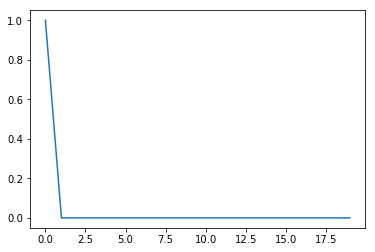

In [133]:
from sklearn.decomposition import PCA
idea_vars = ['IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez',
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential']

pca = PCA()
pca.fit(X[idea_vars])

print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_)
plt.show()

idea_pca = pca.transform(X[idea_vars])

Por lo que tenemos que la primera componente explica el 99.98% de la varianza

In [134]:
idea_vars = ['IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez',
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential']

pca = PCA(n_components=1)
pca.fit(X[idea_vars])

print(pca.explained_variance_ratio_)

idea_pca = pca.transform(X[idea_vars])

[0.99985486]


In [135]:
X['PV_idea_pca'] = idea_pca

In [89]:
X.PV_idea_pca.describe()

count    7.718000e+03
mean    -7.214680e-12
std      7.645892e+04
min     -1.130533e+05
25%     -4.125242e+04
50%     -1.725037e+04
75%      1.270486e+04
max      1.219257e+06
Name: PV_idea_pca, dtype: float64

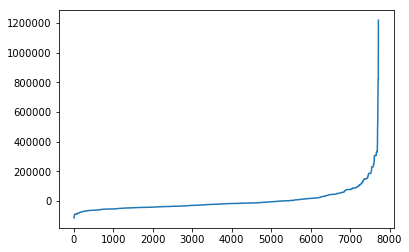

In [90]:
plt.plot(X.PV_idea_pca.sort_values().values)
plt.show()

In [136]:
X['PV_idea_pca2'] = (X.PV_idea_pca - X.PV_idea_pca.min())/(X.PV_idea_pca.max()-X.PV_idea_pca.min())

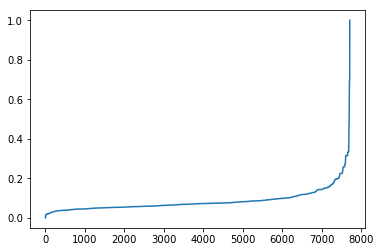

In [92]:
plt.plot(X.PV_idea_pca2.sort_values().values)
plt.show()

In [137]:
X = X.drop(idea_vars, axis = 1)

In [106]:
drop_vars = [
       'PV_idea_pca']
EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5:25.0362 ---> Peor(+0.7264)
KNeighborsRegressor10:23.8845 ---> Peor(+1.1395)
KNeighborsRegressor15:23.1673 ---> Peor(+1.0140)
KNeighborsRegressor25:23.0528 ---> Peor(+0.7704)
KNeighborsRegressor15dist:24.6634 ---> Peor(+1.9142)
DecisionTreeRegressor5:20.1563 ---> Peor(+0.2807)
DecisionTreeRegressor10:26.5949 ---> Mejor(-0.5901)
RandomForestRegressor20:19.3070 ---> Peor(+0.3707)
RandomForestRegressor40:19.2757 ---> Mejor(-0.0671)
RandomForestRegressor50:19.0799 ---> Mejor(-0.0232)
RandomForestRegressor100:19.2469 ---> Peor(+0.0421)
RandomForestRegressor150:19.0836 ---> Mejor(-0.1565)
ExtraTreesRegressor10:21.1515 ---> Peor(+0.3580)
ExtraTreesRegressor50:20.1285 ---> Peor(+0.4639)
ExtraTreesRegressor100:19.8186 ---> Peor(+0.5288)
ExtraTreesRegressor150:19.7377 ---> Peor(+0.3240)
GradientBoostingRegressor30:20.4851 ---> Mejor(-0.0000)
GradientBoostingRegressor50:20.2045 ---> Peor(+0.2742)
GradientBoostingRegressor100:19.9923 ---> Mejor(-0.1682)
GradientBoostingRegresso

In [107]:
drop_vars = [
       'PV_idea_pca2']
EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5:24.5062 ---> Peor(+0.1964)
KNeighborsRegressor10:22.9285 ---> Peor(+0.1834)
KNeighborsRegressor15:22.0212 ---> Mejor(-0.1321)
KNeighborsRegressor25:22.2497 ---> Mejor(-0.0327)
KNeighborsRegressor15dist:22.7625 ---> Peor(+0.0133)
DecisionTreeRegressor5:20.1563 ---> Peor(+0.2807)
DecisionTreeRegressor10:26.8003 ---> Mejor(-0.3847)
RandomForestRegressor20:19.3070 ---> Peor(+0.3707)
RandomForestRegressor40:19.2757 ---> Mejor(-0.0671)
RandomForestRegressor50:19.0799 ---> Mejor(-0.0232)
RandomForestRegressor100:19.2469 ---> Peor(+0.0421)
RandomForestRegressor150:19.0836 ---> Mejor(-0.1565)
ExtraTreesRegressor10:21.1515 ---> Peor(+0.3580)
ExtraTreesRegressor50:20.1285 ---> Peor(+0.4639)
ExtraTreesRegressor100:19.8186 ---> Peor(+0.5288)
ExtraTreesRegressor150:19.7377 ---> Peor(+0.3240)
GradientBoostingRegressor30:20.4851 ---> Mejor(-0.0000)
GradientBoostingRegressor50:20.2045 ---> Peor(+0.2742)
GradientBoostingRegressor100:19.9923 ---> Mejor(-0.1682)
GradientBoostingRegres

In [108]:
drop_vars = [
       'HY_metros_totales',
       'PV_idea_pca', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'PV_cert_energ',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna','PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos','PV_num_banos_1',
       'PV_num_banos_+1']
EntrenarModelos(X, y, models, drop_vars)

KNeighborsRegressor5:24.6893 ---> Peor(+0.3795)
KNeighborsRegressor10:23.9403 ---> Peor(+1.1952)
KNeighborsRegressor15:23.3805 ---> Peor(+1.2272)
KNeighborsRegressor25:22.8582 ---> Peor(+0.5758)
KNeighborsRegressor15dist:24.8177 ---> Peor(+2.0685)
DecisionTreeRegressor5:20.1563 ---> Peor(+0.2807)
DecisionTreeRegressor10:26.5550 ---> Mejor(-0.6300)
RandomForestRegressor20:19.3410 ---> Peor(+0.4047)
RandomForestRegressor40:19.3341 ---> Mejor(-0.0087)
RandomForestRegressor50:19.0916 ---> Mejor(-0.0114)
RandomForestRegressor100:18.9739 ---> Mejor(-0.2309)
RandomForestRegressor150:18.9666 ---> Mejor(-0.2735)
ExtraTreesRegressor10:20.9400 ---> Peor(+0.1466)
ExtraTreesRegressor50:19.5031 ---> Mejor(-0.1615)
ExtraTreesRegressor100:19.1643 ---> Mejor(-0.1255)
ExtraTreesRegressor150:19.2801 ---> Mejor(-0.1337)
GradientBoostingRegressor30:20.4582 ---> Mejor(-0.0269)
GradientBoostingRegressor50:20.1587 ---> Peor(+0.2284)
GradientBoostingRegressor100:19.9612 ---> Mejor(-0.1994)
GradientBoostingRegr

In [105]:
X.columns

Index(['HY_metros_utiles', 'HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio', 'HY_precio_anterior',
       'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
       'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'GA_page_views', 'GA_mean_bounce',
       'GA_exit_rate', 'GA_quincena_ini', 'GA_quincena_ult',
       'PV_precio_anterior', 'PV_longitud_descripcion',
       'PV_longitud_distribucion', 'PV_cantidad_imagenes',
       'PV_ind_elasticidad', 'PV_precio_metro', 'PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1', 'PV_idea_pca', 'PV_idea_p

In [138]:
pca = PCA()
pca.fit(X[['PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1']])

print(pca.explained_variance_ratio_)

[2.39652128e-01 1.32468143e-01 1.10328690e-01 9.01974019e-02
 8.34187783e-02 7.02370710e-02 6.19441275e-02 5.59636129e-02
 5.05257633e-02 4.34850712e-02 3.70464413e-02 2.47327716e-02
 6.54840305e-31 2.59156118e-31 3.70063105e-32 2.53876099e-32
 6.03963731e-33 0.00000000e+00]


In [139]:
pca = PCA(n_components=3)
pca.fit(X[['PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1']])

print(pca.explained_variance_ratio_)

PV_pca = pca.transform(X[['PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1']])

X['PV_pca1'] = PV_pca[:, 0]
X['PV_pca2'] = PV_pca[:, 1]
X['PV_pca3'] = PV_pca[:, 2]

X = X.drop(['PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1'], axis = 1)

[0.23965213 0.13246814 0.11032869]


In [140]:
y = y[X.PV_idea_pca <= X.PV_idea_pca.mean()+3*X.PV_idea_pca.std()]
X = X[X.PV_idea_pca <= X.PV_idea_pca.mean()+3*X.PV_idea_pca.std()]

In [141]:
EntrenarModelos(X, y, models, [])

KNeighborsRegressor5:24.9717 ---> Peor(+0.6619)
KNeighborsRegressor10:23.0201 ---> Peor(+0.2751)
KNeighborsRegressor15:22.5009 ---> Peor(+0.3477)
KNeighborsRegressor25:22.3318 ---> Peor(+0.0494)
KNeighborsRegressor15dist:22.7111 ---> Mejor(-0.0381)
DecisionTreeRegressor5:20.0942 ---> Peor(+0.2186)
DecisionTreeRegressor10:26.5400 ---> Mejor(-0.6450)
RandomForestRegressor20:19.1424 ---> Peor(+0.2062)
RandomForestRegressor40:19.1582 ---> Mejor(-0.1846)
RandomForestRegressor50:18.5789 ---> Mejor(-0.5241)
RandomForestRegressor100:18.8228 ---> Mejor(-0.3820)
RandomForestRegressor150:18.6176 ---> Mejor(-0.6225)
ExtraTreesRegressor10:20.1227 ---> Mejor(-0.6708)
ExtraTreesRegressor50:19.1943 ---> Mejor(-0.4703)
ExtraTreesRegressor100:18.8565 ---> Mejor(-0.4334)
ExtraTreesRegressor150:18.6874 ---> Mejor(-0.7263)
GradientBoostingRegressor30:20.2450 ---> Mejor(-0.2401)
GradientBoostingRegressor50:19.9114 ---> Mejor(-0.0189)
GradientBoostingRegressor100:19.9036 ---> Mejor(-0.2570)
GradientBoostingR

In [142]:
EntrenarModelos(X, y, models, ['PV_idea_pca'])

KNeighborsRegressor5:25.0732 ---> Peor(+0.7634)
KNeighborsRegressor10:24.4468 ---> Peor(+1.7017)
KNeighborsRegressor15:24.2338 ---> Peor(+2.0805)
KNeighborsRegressor25:23.2320 ---> Peor(+0.9496)
KNeighborsRegressor15dist:23.2042 ---> Peor(+0.4550)
DecisionTreeRegressor5:20.0942 ---> Peor(+0.2186)
DecisionTreeRegressor10:27.0400 ---> Mejor(-0.1450)
RandomForestRegressor20:19.1424 ---> Peor(+0.2062)
RandomForestRegressor40:19.1582 ---> Mejor(-0.1846)
RandomForestRegressor50:18.3997 ---> Mejor(-0.7033)
RandomForestRegressor100:18.7433 ---> Mejor(-0.4615)
RandomForestRegressor150:18.6176 ---> Mejor(-0.6225)
ExtraTreesRegressor10:19.9550 ---> Mejor(-0.8384)
ExtraTreesRegressor50:18.8979 ---> Mejor(-0.7667)
ExtraTreesRegressor100:18.9884 ---> Mejor(-0.3014)
ExtraTreesRegressor150:18.9000 ---> Mejor(-0.5137)
GradientBoostingRegressor30:20.2450 ---> Mejor(-0.2401)
GradientBoostingRegressor50:19.9114 ---> Mejor(-0.0189)
GradientBoostingRegressor100:19.9036 ---> Mejor(-0.2570)
GradientBoostingRe

In [143]:
EntrenarModelos(X, y, models, ['PV_idea_pca','HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero',])

KNeighborsRegressor5:25.0980 ---> Peor(+0.7882)
KNeighborsRegressor10:24.4662 ---> Peor(+1.7211)
KNeighborsRegressor15:24.1958 ---> Peor(+2.0426)
KNeighborsRegressor25:23.2422 ---> Peor(+0.9598)
KNeighborsRegressor15dist:23.1984 ---> Peor(+0.4492)
DecisionTreeRegressor5:19.8208 ---> Mejor(-0.0547)
DecisionTreeRegressor10:26.0500 ---> Mejor(-1.1350)
RandomForestRegressor20:19.1424 ---> Peor(+0.2062)
RandomForestRegressor40:19.2399 ---> Mejor(-0.1028)
RandomForestRegressor50:18.6652 ---> Mejor(-0.4379)
RandomForestRegressor100:18.7095 ---> Mejor(-0.4953)
RandomForestRegressor150:18.6363 ---> Mejor(-0.6038)
ExtraTreesRegressor10:20.0728 ---> Mejor(-0.7207)
ExtraTreesRegressor50:18.8522 ---> Mejor(-0.8124)
ExtraTreesRegressor100:18.6518 ---> Mejor(-0.6380)
ExtraTreesRegressor150:18.5795 ---> Mejor(-0.8342)
GradientBoostingRegressor30:20.1634 ---> Mejor(-0.3217)
GradientBoostingRegressor50:19.8585 ---> Mejor(-0.0718)
GradientBoostingRegressor100:19.9061 ---> Mejor(-0.2545)
GradientBoostingR

In [215]:
def EntrenarModelos(X, y, models, drop_vars):
    X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_vars, axis = 1), y, test_size=0.3, random_state=7)
    
    for name, model in models.items():
        #try:
        model = model.fit(X_train, y_train)
        y_test_predict = model.predict(X_test)
        error = median_absolute_error(y_test, y_test_predict)
        
        print(name, ': ', error)

df2 = pd.read_csv('final_data.csv', sep = '|', encoding='utf-8')

X = df2.copy().drop(['TARGET'],axis = 1)
y = df2.TARGET.copy()

EntrenarModelos(X, y, models, ['Unnamed: 0'])

KNeighborsRegressor5 :  23.124000000000002
KNeighborsRegressor10 :  23.411
KNeighborsRegressor15 :  22.959333333333333
KNeighborsRegressor25 :  23.678800000000003
KNeighborsRegressor15dist :  21.7285703761273
DecisionTreeRegressor5 :  20.336907975460093
DecisionTreeRegressor10 :  21.56235294117647
RandomForestRegressor20 :  20.345469494821742
RandomForestRegressor40 :  20.96792180105969
RandomForestRegressor50 :  18.46660553424782
RandomForestRegressor100 :  18.568544987572317
RandomForestRegressor150 :  18.86458175124655
ExtraTreesRegressor10 :  19.043999999999983
ExtraTreesRegressor50 :  18.042799999999993
ExtraTreesRegressor100 :  18.307899999999997
ExtraTreesRegressor150 :  18.02193333333335
GradientBoostingRegressor30 :  21.988153187576643
GradientBoostingRegressor50 :  21.248673220781093
GradientBoostingRegressor100 :  20.943144580683384
GradientBoostingRegressor30_md5 :  19.324628772292762
GradientBoostingRegressor50_md5 :  18.942426735441714
GradientBoostingRegressor100_md5 :  

In [217]:
def EntrenarModelos(X, y, models, drop_vars):
    X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_vars, axis = 1), y, test_size=0.3, random_state=7)
    
    for name, model in models.items():
        #try:
        model = model.fit(X_train, y_train)
        y_test_predict = model.predict(X_test)
        error = median_absolute_error(np.exp(y_test)-1, np.exp(y_test_predict)-1)
        
        print(name, ': ', error)
EntrenarModelos(X, np.log(y+1), models, ['Unnamed: 0'])

KNeighborsRegressor5 :  20.96821903861447
KNeighborsRegressor10 :  20.244594373035675
KNeighborsRegressor15 :  20.017039221342735
KNeighborsRegressor25 :  21.01225189735228
KNeighborsRegressor15dist :  20.45484582309865
DecisionTreeRegressor5 :  16.074624164797576
DecisionTreeRegressor10 :  21.34197652478905
RandomForestRegressor20 :  15.333612570846983
RandomForestRegressor40 :  16.087408927835497
RandomForestRegressor50 :  14.543444183530323
RandomForestRegressor100 :  14.733280017558002
RandomForestRegressor150 :  14.65908692924181
ExtraTreesRegressor10 :  15.323127494681373
ExtraTreesRegressor50 :  14.85958299229614
ExtraTreesRegressor100 :  14.615946935045024
ExtraTreesRegressor150 :  14.714883203594404
GradientBoostingRegressor30 :  16.72896078342528
GradientBoostingRegressor50 :  16.731930606937304
GradientBoostingRegressor100 :  15.922229702918452
GradientBoostingRegressor30_md5 :  15.332290055266949
GradientBoostingRegressor50_md5 :  15.385355164750528
GradientBoostingRegresso

In [212]:
X.columns

Index(['HY_id', 'HY_cod_postal', 'HY_provincia', 'HY_descripcion',
       'HY_distribucion', 'HY_tipo', 'HY_antiguedad', 'HY_metros_utiles',
       'HY_metros_totales', 'HY_num_banos', 'HY_cert_energ', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_num_garajes', 'HY_precio',
       'HY_precio_anterior', 'IDEA_area', 'IDEA_poblacion', 'IDEA_densidad',
       'IDEA_pc_1960', 'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
       'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_elasticidad', 'IDEA_ind_liquidez',
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_res

In [146]:
EntrenarModelos(X, y, models, ['PV_idea_pca','HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio_anterior', 'PV_longitud_distribucion'])

KNeighborsRegressor5:25.0532 ---> Peor(+0.7433)
KNeighborsRegressor10:24.9679 ---> Peor(+2.2228)
KNeighborsRegressor15:24.4095 ---> Peor(+2.2562)
KNeighborsRegressor25:23.5791 ---> Peor(+1.2967)
KNeighborsRegressor15dist:23.4798 ---> Peor(+0.7306)
DecisionTreeRegressor5:19.6989 ---> Mejor(-0.1767)
DecisionTreeRegressor10:27.9100 ---> Peor(+0.7250)
RandomForestRegressor20:19.0714 ---> Peor(+0.1351)
RandomForestRegressor40:19.2355 ---> Mejor(-0.1073)
RandomForestRegressor50:18.4911 ---> Mejor(-0.6119)
RandomForestRegressor100:18.4043 ---> Mejor(-0.8005)
RandomForestRegressor150:18.5105 ---> Mejor(-0.7296)
ExtraTreesRegressor10:20.6326 ---> Mejor(-0.1608)
ExtraTreesRegressor50:19.2256 ---> Mejor(-0.4390)
ExtraTreesRegressor100:19.1889 ---> Mejor(-0.1009)
ExtraTreesRegressor150:18.9654 ---> Mejor(-0.4483)
GradientBoostingRegressor30:20.1634 ---> Mejor(-0.3217)
GradientBoostingRegressor50:19.9602 ---> Peor(+0.0299)
GradientBoostingRegressor100:19.9490 ---> Mejor(-0.2116)
GradientBoostingReg

In [190]:
X.columns

Index(['HY_metros_utiles', 'HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio', 'HY_precio_anterior',
       'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
       'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'GA_page_views', 'GA_mean_bounce',
       'GA_exit_rate', 'GA_quincena_ini', 'GA_quincena_ult',
       'PV_precio_anterior', 'PV_longitud_descripcion',
       'PV_longitud_distribucion', 'PV_cantidad_imagenes',
       'PV_ind_elasticidad', 'PV_precio_metro', 'PV_idea_pca', 'PV_idea_pca2',
       'PV_pca1', 'PV_pca2', 'PV_pca3'],
      dtype='object')

In [197]:
def EntrenarModelos(X, y, models, drop_vars):
    X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_vars, axis = 1), y, test_size=0.3, random_state=7)
    
    # Diccionario que guarda el modelo con el minimo error
    minimo = {'':np.inf}
    for name, model in models.items():
        #try:
        model = model.fit(X_train, y_train)
        y_test_predict = model.predict(X_test)
        error = median_absolute_error(np.exp(y_test)-1, np.exp(y_test_predict)-1)
        
        print('{}: {:.4f}'.format(name, error))
        
        if list(minimo.values())[0]  > error:
            minimo = {name:error}
    
    return minimo

In [194]:
# Entrenamos varios XGBoost
models = {}
for i in range(10,200, 10):
    for j in np.arange(0.5, 1.01, 0.1):
        for k in [0.2, 0.1, 0.05, 0.01]:
            models['XGB_{}_{}_{}'.format(i, j, k)] = XGBRegressor(max_depth = 10, 
                                                                  n_estimators= i, 
                                                                  reg_lambda = j,
                                                                  learning_rate = k, 
                                                                  objective = 'reg:linear',
                                                                  random_state=7)
#print('Models:', models)
print('Se van a entrenar:', len(models), 'modelos')
EntrenarModelos(X, y, models, ['PV_idea_pca','HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio_anterior'])

Se van a entrenar: 456 modelos
XGB_10_0.5_0.2: 21.2903
XGB_10_0.5_0.1: 39.3389
XGB_10_0.5_0.05: 48.8503
XGB_10_0.5_0.01: 53.2720
XGB_10_0.6_0.2: 20.3218
XGB_10_0.6_0.1: 39.2080
XGB_10_0.6_0.05: 48.9653
XGB_10_0.6_0.01: 53.2715
XGB_10_0.7_0.2: 20.5837
XGB_10_0.7_0.1: 39.1148
XGB_10_0.7_0.05: 48.8495
XGB_10_0.7_0.01: 53.2735
XGB_10_0.7999999999999999_0.2: 20.3427
XGB_10_0.7999999999999999_0.1: 39.1678
XGB_10_0.7999999999999999_0.05: 48.9034
XGB_10_0.7999999999999999_0.01: 53.2744
XGB_10_0.8999999999999999_0.2: 20.0479
XGB_10_0.8999999999999999_0.1: 39.5104
XGB_10_0.8999999999999999_0.05: 48.9637
XGB_10_0.8999999999999999_0.01: 53.2773
XGB_10_0.9999999999999999_0.2: 20.9486
XGB_10_0.9999999999999999_0.1: 39.2343
XGB_10_0.9999999999999999_0.05: 48.9214
XGB_10_0.9999999999999999_0.01: 53.2835
XGB_20_0.5_0.2: 19.0880
XGB_20_0.5_0.1: 21.3456
XGB_20_0.5_0.05: 39.9651
XGB_20_0.5_0.01: 52.4209
XGB_20_0.6_0.2: 18.9131
XGB_20_0.6_0.1: 21.2928
XGB_20_0.6_0.05: 39.8149
XGB_20_0.6_0.01: 52.4210
XGB_2

XGB_110_0.8999999999999999_0.2: 19.1297
XGB_110_0.8999999999999999_0.1: 19.1978
XGB_110_0.8999999999999999_0.05: 18.6141
XGB_110_0.8999999999999999_0.01: 38.3274
XGB_110_0.9999999999999999_0.2: 20.0518
XGB_110_0.9999999999999999_0.1: 18.8137
XGB_110_0.9999999999999999_0.05: 18.7663
XGB_110_0.9999999999999999_0.01: 38.2923
XGB_120_0.5_0.2: 19.5543
XGB_120_0.5_0.1: 19.2827
XGB_120_0.5_0.05: 18.3654
XGB_120_0.5_0.01: 36.1743
XGB_120_0.6_0.2: 19.6568
XGB_120_0.6_0.1: 19.4908
XGB_120_0.6_0.05: 19.2798
XGB_120_0.6_0.01: 36.1771
XGB_120_0.7_0.2: 20.0379
XGB_120_0.7_0.1: 18.9526
XGB_120_0.7_0.05: 19.0177
XGB_120_0.7_0.01: 36.1765
XGB_120_0.7999999999999999_0.2: 19.6819
XGB_120_0.7999999999999999_0.1: 18.5682
XGB_120_0.7999999999999999_0.05: 18.7587
XGB_120_0.7999999999999999_0.01: 36.0096
XGB_120_0.8999999999999999_0.2: 19.1523
XGB_120_0.8999999999999999_0.1: 19.2641
XGB_120_0.8999999999999999_0.05: 18.7641
XGB_120_0.8999999999999999_0.01: 36.0199
XGB_120_0.9999999999999999_0.2: 20.0549
XGB_12

{'XGB_40_0.7999999999999999_0.1': 17.871086425781243}

Se van a entrenar: 456 modelos
XGB_10_0.5_0.2: 20.9142
XGB_10_0.5_0.1: 39.2475
XGB_10_0.5_0.05: 48.8512
XGB_10_0.5_0.01: 53.2765
XGB_10_0.6_0.2: 20.4047
XGB_10_0.6_0.1: 39.1456
XGB_10_0.6_0.05: 48.9728
XGB_10_0.6_0.01: 53.2715
XGB_10_0.7_0.2: 20.2025
XGB_10_0.7_0.1: 39.3873
XGB_10_0.7_0.05: 49.0034
XGB_10_0.7_0.01: 53.2735
XGB_10_0.7999999999999999_0.2: 20.5497
XGB_10_0.7999999999999999_0.1: 39.2861
XGB_10_0.7999999999999999_0.05: 48.9462
XGB_10_0.7999999999999999_0.01: 53.2744
XGB_10_0.8999999999999999_0.2: 20.3624
XGB_10_0.8999999999999999_0.1: 39.2179
XGB_10_0.8999999999999999_0.05: 49.0317
XGB_10_0.8999999999999999_0.01: 53.2785
XGB_10_0.9999999999999999_0.2: 20.7062
XGB_10_0.9999999999999999_0.1: 39.2419
XGB_10_0.9999999999999999_0.05: 48.9849
XGB_10_0.9999999999999999_0.01: 53.2801
XGB_20_0.5_0.2: 18.8156
XGB_20_0.5_0.1: 20.9320
XGB_20_0.5_0.05: 39.9123
XGB_20_0.5_0.01: 52.4212
XGB_20_0.6_0.2: 19.5058
XGB_20_0.6_0.1: 21.2775
XGB_20_0.6_0.05: 39.8215
XGB_20_0.6_0.01: 52.4934
XGB_2

XGB_110_0.8999999999999999_0.2: 20.3146
XGB_110_0.8999999999999999_0.1: 18.7584
XGB_110_0.8999999999999999_0.05: 18.7567
XGB_110_0.8999999999999999_0.01: 38.1974
XGB_110_0.9999999999999999_0.2: 19.5419
XGB_110_0.9999999999999999_0.1: 18.8316
XGB_110_0.9999999999999999_0.05: 18.6325
XGB_110_0.9999999999999999_0.01: 38.2162
XGB_120_0.5_0.2: 19.8452
XGB_120_0.5_0.1: 18.9214
XGB_120_0.5_0.05: 18.9380
XGB_120_0.5_0.01: 36.0116
XGB_120_0.6_0.2: 20.1876
XGB_120_0.6_0.1: 19.4619
XGB_120_0.6_0.05: 19.1866
XGB_120_0.6_0.01: 36.0214
XGB_120_0.7_0.2: 20.3303
XGB_120_0.7_0.1: 19.3402
XGB_120_0.7_0.05: 18.9641
XGB_120_0.7_0.01: 36.0854
XGB_120_0.7999999999999999_0.2: 19.7391
XGB_120_0.7999999999999999_0.1: 19.0867
XGB_120_0.7999999999999999_0.05: 18.7463
XGB_120_0.7999999999999999_0.01: 35.9151
XGB_120_0.8999999999999999_0.2: 20.3916
XGB_120_0.8999999999999999_0.1: 18.6988
XGB_120_0.8999999999999999_0.05: 18.8381
XGB_120_0.8999999999999999_0.01: 36.1436
XGB_120_0.9999999999999999_0.2: 19.6738
XGB_12

{'XGB_60_0.9999999999999999_0.05': 17.820088348388637}

In [188]:
def EntrenarModelos2(X, y, models, drop_vars, y_min, y_max):
    X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_vars, axis = 1), y, test_size=0.3, random_state=7)
    
    # Diccionario que guarda el modelo con el minimo error
    minimo = {'':np.inf}
    for name, model in models.items():
        #try:
        model = model.fit(X_train, y_train)
        y_test_predict = model.predict(X_test)
        error = median_absolute_error((np.exp(y_test*(y_max-y_min)+y_min)-1), (np.exp(y_test_predict*(y_max-y_min)+y_min)-1))
        
        print('{}: {:.4f}'.format(name, error))
        
        if list(minimo.values())[0]  > error:
            minimo = {name:error}
            
    return minimo

In [195]:
y_01 = (y-y.min())/(y.max()-y.min())

for i in range(10,200, 10):
    for j in np.arange(0.5, 1.01, 0.1):
        for k in [0.2, 0.1, 0.05, 0.01]:
            models['XGB_{}_{}_{}'.format(i, j, k)] = XGBRegressor(max_depth = 10, 
                                                                  n_estimators= i, 
                                                                  reg_lambda = j,
                                                                  learning_rate = k, 
                                                                  objective = 'reg:logistic',
                                                                  random_state=7)
#print('Models:', models)
print('Se van a entrenar:', len(models), 'modelos')
EntrenarModelos2(X, y_01, models, ['PV_idea_pca','HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio_anterior'], y_min = y.min(), y_max = y.max())

Se van a entrenar: 456 modelos
XGB_10_0.5_0.2: 18.1002
XGB_10_0.5_0.1: 21.0369
XGB_10_0.5_0.05: 27.0033
XGB_10_0.5_0.01: 35.0641
XGB_10_0.6_0.2: 18.2995
XGB_10_0.6_0.1: 20.4191
XGB_10_0.6_0.05: 26.8749
XGB_10_0.6_0.01: 35.0903
XGB_10_0.7_0.2: 18.2016
XGB_10_0.7_0.1: 20.5443
XGB_10_0.7_0.05: 27.0941
XGB_10_0.7_0.01: 35.0986
XGB_10_0.7999999999999999_0.2: 18.0770
XGB_10_0.7999999999999999_0.1: 20.6249
XGB_10_0.7999999999999999_0.05: 27.2266
XGB_10_0.7999999999999999_0.01: 35.1002
XGB_10_0.8999999999999999_0.2: 18.2400
XGB_10_0.8999999999999999_0.1: 20.4288
XGB_10_0.8999999999999999_0.05: 27.0853
XGB_10_0.8999999999999999_0.01: 35.1018
XGB_10_0.9999999999999999_0.2: 17.7991
XGB_10_0.9999999999999999_0.1: 20.2880
XGB_10_0.9999999999999999_0.05: 26.9832
XGB_10_0.9999999999999999_0.01: 35.0791
XGB_20_0.5_0.2: 18.8441
XGB_20_0.5_0.1: 18.1406
XGB_20_0.5_0.05: 20.4134
XGB_20_0.5_0.01: 32.9707
XGB_20_0.6_0.2: 19.3655
XGB_20_0.6_0.1: 18.2976
XGB_20_0.6_0.05: 20.7168
XGB_20_0.6_0.01: 32.9213
XGB_2

XGB_110_0.8999999999999999_0.2: 19.9923
XGB_110_0.8999999999999999_0.1: 19.4687
XGB_110_0.8999999999999999_0.05: 18.8404
XGB_110_0.8999999999999999_0.01: 20.0759
XGB_110_0.9999999999999999_0.2: 19.7471
XGB_110_0.9999999999999999_0.1: 19.3312
XGB_110_0.9999999999999999_0.05: 18.8627
XGB_110_0.9999999999999999_0.01: 20.0278
XGB_120_0.5_0.2: 19.5622
XGB_120_0.5_0.1: 19.3273
XGB_120_0.5_0.05: 18.6834
XGB_120_0.5_0.01: 20.0934
XGB_120_0.6_0.2: 19.8976
XGB_120_0.6_0.1: 19.3938
XGB_120_0.6_0.05: 18.9642
XGB_120_0.6_0.01: 20.1186
XGB_120_0.7_0.2: 19.8239
XGB_120_0.7_0.1: 19.5388
XGB_120_0.7_0.05: 19.0059
XGB_120_0.7_0.01: 19.8773
XGB_120_0.7999999999999999_0.2: 20.2183
XGB_120_0.7999999999999999_0.1: 19.1253
XGB_120_0.7999999999999999_0.05: 18.7983
XGB_120_0.7999999999999999_0.01: 19.8778
XGB_120_0.8999999999999999_0.2: 20.1541
XGB_120_0.8999999999999999_0.1: 19.3392
XGB_120_0.8999999999999999_0.05: 18.9773
XGB_120_0.8999999999999999_0.01: 19.7475
XGB_120_0.9999999999999999_0.2: 19.7174
XGB_12

{'XGB_40_0.7999999999999999_0.05': 17.788521270751957}

# Tunning XGBoost

In [199]:
models = {}
for i in np.arange(0.5, 1.01, 0.1):
    for j in np.arange(0.5, 1.01, 0.1):
        for k in [3, 2, 1, 0.1, 0.05, 0.01, 0.005]:
            models['XGB_{}_{}_{}'.format(i, j, k)] = XGBRegressor(max_depth = 10, 
                                                                  n_estimators= 40, 
                                                                  reg_lambda = 0.8,
                                                                  subsample = i,
                                                                  colsample_bytree = j,
                                                                  eta = k,
                                                                  objective = 'reg:linear',
                                                                  random_state=7)

In [200]:
print('Se van a entrenar:', len(models), 'modelos')
EntrenarModelos(X, y, models, ['PV_idea_pca','HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio_anterior'])

Se van a entrenar: 252 modelos
XGB_0.5_0.5_3: 18.0870
XGB_0.5_0.5_2: 18.0870
XGB_0.5_0.5_1: 18.0870
XGB_0.5_0.5_0.1: 18.0870
XGB_0.5_0.5_0.05: 18.0870
XGB_0.5_0.5_0.01: 18.0870
XGB_0.5_0.5_0.005: 18.0870
XGB_0.5_0.6_3: 17.7130
XGB_0.5_0.6_2: 17.7130
XGB_0.5_0.6_1: 17.7130
XGB_0.5_0.6_0.1: 17.7130
XGB_0.5_0.6_0.05: 17.7130
XGB_0.5_0.6_0.01: 17.7130
XGB_0.5_0.6_0.005: 17.7130
XGB_0.5_0.7_3: 18.0748
XGB_0.5_0.7_2: 18.0748
XGB_0.5_0.7_1: 18.0748
XGB_0.5_0.7_0.1: 18.0748
XGB_0.5_0.7_0.05: 18.0748
XGB_0.5_0.7_0.01: 18.0748
XGB_0.5_0.7_0.005: 18.0748
XGB_0.5_0.7999999999999999_3: 17.8908
XGB_0.5_0.7999999999999999_2: 17.8908
XGB_0.5_0.7999999999999999_1: 17.8908
XGB_0.5_0.7999999999999999_0.1: 17.8908
XGB_0.5_0.7999999999999999_0.05: 17.8908
XGB_0.5_0.7999999999999999_0.01: 17.8908
XGB_0.5_0.7999999999999999_0.005: 17.8908
XGB_0.5_0.8999999999999999_3: 18.3097
XGB_0.5_0.8999999999999999_2: 18.3097
XGB_0.5_0.8999999999999999_1: 18.3097
XGB_0.5_0.8999999999999999_0.1: 18.3097
XGB_0.5_0.89999999

XGB_0.9999999999999999_0.5_0.05: 18.6063
XGB_0.9999999999999999_0.5_0.01: 18.6063
XGB_0.9999999999999999_0.5_0.005: 18.6063
XGB_0.9999999999999999_0.6_3: 18.5346
XGB_0.9999999999999999_0.6_2: 18.5346
XGB_0.9999999999999999_0.6_1: 18.5346
XGB_0.9999999999999999_0.6_0.1: 18.5346
XGB_0.9999999999999999_0.6_0.05: 18.5346
XGB_0.9999999999999999_0.6_0.01: 18.5346
XGB_0.9999999999999999_0.6_0.005: 18.5346
XGB_0.9999999999999999_0.7_3: 18.3431
XGB_0.9999999999999999_0.7_2: 18.3431
XGB_0.9999999999999999_0.7_1: 18.3431
XGB_0.9999999999999999_0.7_0.1: 18.3431
XGB_0.9999999999999999_0.7_0.05: 18.3431
XGB_0.9999999999999999_0.7_0.01: 18.3431
XGB_0.9999999999999999_0.7_0.005: 18.3431
XGB_0.9999999999999999_0.7999999999999999_3: 18.8154
XGB_0.9999999999999999_0.7999999999999999_2: 18.8154
XGB_0.9999999999999999_0.7999999999999999_1: 18.8154
XGB_0.9999999999999999_0.7999999999999999_0.1: 18.8154
XGB_0.9999999999999999_0.7999999999999999_0.05: 18.8154
XGB_0.9999999999999999_0.7999999999999999_0.01: 18

{'XGB_0.5_0.6_3': 17.713035583496094}

In [221]:
y.max()

172.0